# pwy_summary

In [1]:
import pandas as pd
import cobra
import itertools
from typing import Dict, List
from collections import defaultdict
import ast
import os
import numpy as npfrom pandas.api.types import CategoricalDtype

E0 = cobra.io.read_sbml_model("./models/iML1515_E0.xml")
S0 = cobra.io.read_sbml_model("./models/STM_v1_0_S0.xml")
E0.id = 'E0'
S0.id = 'S0.ac'
# reactions in TAC or other pathways

desired_cycle = pd.read_csv('./Data/desired_cycle.csv', index_col=0) #flux analysis.ipynb
gr_DG = pd.read_csv('./r/data fitting/standardized_gr_Div_DG_Mult_Aug31.csv', index_col='gene_inhibition')
gr_DG.loc[:,:'S0.ac_monoculture'][gr_DG.loc[:,:'S0.ac_monoculture']<1e-5] = 0 

label_df = pd.read_excel(open('./Data/iML1515_GP.xlsx', 'rb'), # ? S0 rct pathway label necessary?
              sheet_name='iML1515_GP', index_col=0)
# rct_pathway_df = pd.read_csv('./Data/rct_pathway.csv')
alpha_table = pd.read_csv("./Data/alpha_table.csv", index_col=0)
comb_list = list(pd.read_csv('./Data/gr_Div_DG_Blis_Aug31.csv').gene_inhibition[1:])
DG_list = list(gr_DG.index)
DG_list.remove('Normal')
genes = alpha_table.index

In [2]:
def convert_arg_to_list(arg):
    if type(arg) is pd.Series:
        arg = list(arg) 
    elif type(arg) not in [list, tuple, set]:
        arg = [arg] # differ from list(arg) -> conversion of str
    return arg

def get_Biomass_df(files):
    return pd.concat(
            [pd.read_csv(file, index_col='cycle')
             for file in convert_arg_to_list(files)]
        ,axis=1)

Biomass_df = get_Biomass_df(['./Data/BM_SG1.csv', './Data/BM_DG1.csv'])

# desired cycle 


In [3]:
# pd.set_option('display.max_rows', 2000)
# display(HTML("<style>.container { width:40% !important; }</style>"))

In [4]:
log_step=5

def search_gr_cycle_with_biomass(df_search, biomass_values):
    return [df_search[df_search >= biomass_value].idxmin() 
                for biomass_value in convert_arg_to_list(biomass_values)]

def get_cycle_max_gr(desired_BM):
    max_gr = desired_BM.iloc[-1]/2
    bool_growing = ((desired_BM.iloc[-1]-desired_BM.iloc[-5])/desired_BM.iloc[-1]).apply(lambda x: x > 1e-10)
    for k, bool_grow in bool_growing.items():
        if bool_grow:
            max_gr[k] = desired_BM[k].iloc[-6]
    biomass_diff = (Biomass_df.iloc[-1]-Biomass_df.iloc[0])
    start = Biomass_df.iloc[0] + biomass_diff*0.1
    end = Biomass_df.iloc[0] + biomass_diff*0.9
    
    return max_gr, start, end, bool_growing

def find_down_neighbour(df):
    max_gr = get_cycle_max_gr(df)
    position = list()
    
    def correct_cycle(cycle):
        mod = cycle%log_step
#         return cycle if mod==0 else cycle+log_step-mod # round up
        return cycle if mod==0 else cycle-mod # round down
#   
    gr_cycle = defaultdict(dict)
    for gcomb, biomass_value in max_gr.items():
        df_search = df.loc[:,gcomb]
        upperneighbour_ind =  search_gr_cycle_with_biomass(df_search, biomass_value) # 0 if growth belolw 1e-8 
#         gr_cycle[gcomb] = correct_cycle(upperneighbour_ind) 
        gr_cycle[gcomb].update({'cycle': correct_cycle(upperneighbour_ind),
                                'growth phase': [search_gr_cycle_with_biomass(),
                                                search_gr_cycle_with_biomass()]})
    return gr_cycle

# def get_desired_cycle_df():
#     desired_cycle_dict = defaultdict(dict)
#     for k, cycle in find_down_neighbour(Biomass_df).items():
#         key_items = k.split('_')
#         gcomb = key_items.pop(1)
#         col_name = '_'.join(key_items)
#         if desired_cycle_dict[gcomb].get(col_name):
#             sys.exit("Halt, Gene comb keys get overwritten")
#         desired_cycle_dict[gcomb].update({col_name: cycle})

#     return pd.DataFrame.from_dict(desired_cycle_dict, orient='index')


In [5]:
def get_desired_cycle(desired_biomass_df):
    def correct_cycle(cycle):
        mod = cycle%log_step
    #         return cycle if mod==0 else cycle+log_step-mod # round up
        return cycle if mod==0 else cycle-mod # round down

    def get_growth_phase_length():
        return ((desired_cycle['end'] - desired_cycle['start'])*(1-desired_cycle.bool_growing) + # if not growing, not changing growth phase length
                999*(desired_cycle.bool_growing)) #if growing, set growth length to 999

    desired_cycle = (desired_biomass_df.iloc[:-1]
                  .apply(lambda x: 
                         search_gr_cycle_with_biomass(Biomass_df.loc[:,x.name],x))
                  .T)
    def split_index_to_cols(df):
        return pd.DataFrame(zip(*df.index.str.split('_')), index=['Species', 'Gene_inhibition', 'culture'], columns=df.index).T
    desired_cycle['bool_growing'] = desired_biomass_df.T.bool_growing
    desired_cycle['cycle_max_gr'] = desired_cycle['max_gr'].apply(correct_cycle) # -> cycle_max_gr
    desired_cycle['growth_phase'] = desired_cycle[['start', 'end']].values.tolist()
    desired_cycle['growth_phase_length'] = get_growth_phase_length()
    desired_cycle = desired_cycle.join(split_index_to_cols(desired_cycle))
#     .query('culture=="coculture"')
    desired_cycle = desired_cycle.set_index('Gene_inhibition')[['cycle_max_gr', 'bool_growing', 'growth_phase_length', 'Species','culture']]
    
    return desired_cycle

In [6]:
desired_biomass_df = pd.DataFrame(get_cycle_max_gr(Biomass_df), index=['max_gr', 'start', 'end', 'bool_growing'])
desired_cycle = get_desired_cycle(desired_biomass_df)

# PWY

In [7]:
def get_gene_id(model, gene_name):
    for i in model.genes:
        if(i.name == gene_name):
            return(i.id)

def record_rct(model, current_gene):
    return [rct.id for rct in model.genes.get_by_id(get_gene_id(model, current_gene)).reactions]

def pwy_dict_to_df(pwy_dict):
    df = pd.DataFrame.from_dict({k: ' + '.join(v) for k, v in pwy_dict.items()},
#     df = pd.DataFrame.from_dict({k: '+'.join(v) for k, v in pwy_dict.items()},
                       orient='index', columns=['Pathway'])
    df.index.name = 'Gene_inhibition'
    return df

def convert_dict_to_long_df(d: dict, cols: list):
    gcomb_pwy_list = list()
    for gcomb, pwys in d.items():
        for pwy in pwys:
            gcomb_pwy_list.append([gcomb, pwy])
#     index_col = [col for col in cols if col in 'Gene_inhibition|Reaction']
    df = pd.DataFrame.from_records(gcomb_pwy_list, columns=cols)
    return df

def get_SG_pwy_dict(model):
    gene_rct_dict = defaultdict(list)
    for current_gene in alpha_table.index:
        gene_rct_dict[f'{current_gene}'] = record_rct(model, current_gene)
    
    gene_pwy_dict = defaultdict(list)
    for current_gene,rcts in gene_rct_dict.items():
        for current_reaction in rcts:
            try:
                label = label_df.loc[f'{current_reaction}', 'm_subsystem']
                label = label if type(label) == str else label[0]
                gene_pwy_dict[f'{current_gene}'].append(label)
            except:
                print(current_gene, f'reaction {current_reaction} not exist in list')
        gene_pwy_dict[f'{current_gene}'] = set(convert_arg_to_list(gene_pwy_dict[f'{current_gene}'])) | set(gene_pwy_dict[f'{current_gene}'])
    return gene_pwy_dict

def get_gene_pathway_df(model):
    pwy_dict = get_SG_pwy_dict(model)
    DG_pwy_dict = get_DG_pwy_dict(pwy_dict)
    
    pwy_dict.update(DG_pwy_dict)
    
    gene_pathway_df = convert_dict_to_long_df(pwy_dict, ['Gene_inhibition', 'Pathway'])
    gene_pathway_df['XG'] = gene_pathway_df.Gene_inhibition.str.split('.').apply(
        lambda x: 'SG' if len(x)==1 else 'DG') 
    return gene_pathway_df

def antagonistic_count(genes:list):
    antagonistic_set = ['dadX.rffG', 'dadX.pyrD', 'acnB.thrB', 'acnB.thrB', 'acnB.thrB',
       'aroA.argD', 'aroA.argD', 'aroA.argD', 'dadX.guaB', 'aroA.dapB',
       'aroA.guaB']
    return list((set(genes).intersection(antagonistic_set)))

def get_ratio_col(gene_count_df):
    DG = gene_count_df.query('XG=="DG"').reset_index(drop=True).copy()
    DG['Antagonistic_gcomb'] = DG.Gene_list.apply(lambda x: antagonistic_count(x.split(', ')))
#     DG['Antagonistic_ratio'] = DG.Antagonistic_gcomb.str.split(', ').map(len)
    DG['Antagonistic_ratio'] = pd.Series(map(len, DG.Antagonistic_gcomb.tolist()))/DG.Gene_count
    DG['Antagonistic_gcomb'] = DG['Antagonistic_gcomb'].apply(lambda x: ', '.join(x))
    
    return DG[['Pathway', 'Antagonistic_ratio', 'Antagonistic_gcomb']]

def get_gene_count_df(gene_pathway_df):

    gene_count_df = (gene_pathway_df.groupby(['Pathway','XG'], as_index=False).agg(
                        Gene_list=('Gene_inhibition', lambda x: ', '.join(x.values)),
                        Gene_count=('Gene_inhibition', 'count')))
    gene_count_df = gene_count_df.merge(get_ratio_col(gene_count_df), on='Pathway')
    (gene_count_df.pivot(index=['Pathway','Antagonistic_ratio', 'Antagonistic_gcomb'], columns=['XG'], values=['Gene_list','Gene_count'])
         .sort_values(by=('Gene_count','DG'), ascending=False)).to_csv('./Data/gene_count.csv')
    return gene_count_df

def get_single_pathway_df(gene_pathway_df):
    # add p_o afterwards
    df = (gene_pathway_df.groupby(['Gene_inhibition','XG'], as_index=False).agg(
        Pathway_count=('Pathway', 'count'),
        Pathway_list = ('Pathway', lambda x: list(x.values))))
#         P = ('Pathway', lambda x: pd.DataFrame(x.values))))
    df['Single_pathway'] = pd.cut(df['Pathway_count'], [0,1,10], labels = ['Single_pathway', 'Multi_pathway'])
    return df.sort_values(['Pathway_count', 'XG'], ascending=True).set_index('Gene_inhibition')


In [8]:
def get_rct_pathway_df():
    pwy_rct_dict = defaultdict(list)
    for index, sub_df in label_df[['m_subsystem']].iterrows():
        pwy_rct_dict[sub_df[0]].append(index)
    rct_pathway_df = convert_dict_to_long_df(pwy_rct_dict,['Pathway','Reaction'])
    return rct_pathway_df.drop_duplicates()

In [9]:
def get_DG_pwy_dict(SG_pwy_dict):
    comb_list = list(pd.read_csv('./Data/gr_Div_DG_Blis_Aug31.csv').gene_inhibition[1:])
    DG_pwy_dict = dict()
    # for DG_pwy in comb_list:
    gene_pathway_row = list()
    for DG_pwy in comb_list:
        gene_pair = DG_pwy.split('.')
        DG_pwy_dict[DG_pwy] = SG_pwy_dict[gene_pair[0]] | SG_pwy_dict[gene_pair[1]] 
    return DG_pwy_dict

In [10]:
rct_pathway_df = get_rct_pathway_df()
gene_pathway_df = get_gene_pathway_df(E0)

gene_count_df=get_gene_count_df(gene_pathway_df)
single_pathway_df = get_single_pathway_df(gene_pathway_df)

thrB reaction 4HTHRK not exist in list
glyA reaction THRA2 not exist in list
glyA reaction THRA not exist in list


# p_o

In [11]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [12]:
def get_syn_df(gr_XG, model):
    model_id = model.id
    additive_threshold = .01
    diff_bins = [-10,-1*additive_threshold,1*additive_threshold,10]
    gr_bins = [-1,.2,1,10]
    
    if gr_XG.index.name == 'gene_inhibition':
        gr_XG.index.name = 'Gene_inhibition'
    syn_df  = pd.DataFrame([], index=gr_DG.index)
    syn_df['Predicted_growth_rate'] = gr_XG[f'Predicted_additive_effect_{model.id}_coculture']
    syn_df['Observed_growth_rate'] = gr_XG[f'{model.id}_coculture']
    syn_df['P_O'] = syn_df.Predicted_growth_rate - syn_df.Observed_growth_rate
    syn_df['Drug_comb_effect'] = pd.cut(syn_df['P_O'], bins=diff_bins, labels=['Antagonistic', 'Additive', 'Synergistic'])
    
    syn_df['PGR_bin'] = pd.cut(syn_df['Predicted_growth_rate'], bins=gr_bins, labels=['Low', 'Normal', 'High'])
    syn_df['OGR_bin'] = pd.cut(syn_df['Observed_growth_rate'], bins=gr_bins, labels=['Low', 'Normal', 'High'])
    
    syn_df.loc[(syn_df.Predicted_growth_rate < 1.5e-8) & (syn_df.Observed_growth_rate < 1.5e-8),'P_O'] = 0
    syn_df['gene_sort'] = (syn_df['P_O'] < 0)*10 + abs(syn_df['P_O'])
    syn_df['Species'] = model.id
    return syn_df

def get_antagonistic_df(syn_df):
    antagonistic_list = syn_df.loc[syn_df['P_O']<0].query("P_O<-0.01").index 
    # ? func get pwy col
    potential_pwy = (gene_combo_pathway
                                      .loc[antagonistic_list,'Pathway']
                                      .str.split(' \+ ') # series string need \+
                                      .apply(lambda x: sorted(x))) 
    return pd.DataFrame(potential_pwy)

def remove_nan_from(x: pd.Series):
    return x.apply(lambda x: sorted(list(itertools.compress(x,[ele not in [None, np.nan] for ele in x]))))
  

In [13]:
def get_p_o_df():
    single_pathway_df = pd.read_csv('./Data/single_pathway_df.csv')
    gcomb_single_pathway_df = single_pathway_df.query('XG=="DG"') # select only DG
    p_o = pd.concat([get_syn_df(gr_DG, E0), get_syn_df(gr_DG, S0)])
    p_o = p_o.merge(gcomb_single_pathway_df.drop('XG', axis=1), left_index=True, right_on='Gene_inhibition', how='outer')
    return p_o.set_index('Gene_inhibition')

In [14]:
p_o_full = get_p_o_df()

# flux

In [618]:
def get_gene_id(model, gene_name):
    for i in model.genes:
        if(i.name == gene_name):
            return(i.id)

def get_rcts_list(model, gcomb_list): 
    rcts_list = list()
    rcts_set = set()
    for i, gene in enumerate(gcomb_list):
        gene_rcts = [rct.id for rct in model.genes.get_by_id(get_gene_id(model, gene)).reactions]
        if i > 0:
            gene_rcts = list(set(gene_rcts) - rcts_set)
        rcts_list.append(gene_rcts)
        rcts_set = rcts_set | set(gene_rcts)
    return rcts_list

def adjust_flux_df(model, df, gene_combo: list):
    if 'Normal' not in gene_combo:
#         gene_combo_dict = get_gcomb_alpha_dict(gene_combo) 
        v1_cols = df.filter(regex='v1').columns
        orig_cols = [ele.replace("_v1", '') for ele in df.filter(regex='v1').columns]
        
        gene_combo_list = gene_combo.split('.')
        rcts_list = get_rcts_list(model, gene_combo_list)
        scaled_rcts = list()
        for gene, rcts in zip(gene_combo_list, rcts_list):  
            rcts = [rct for rct in rcts if rct in orig_cols]
            for orig_col in rcts:
                alpha = alpha_table.loc[f'{gene}', f'{model.id}']   
                v1_col = orig_col + "_v1"
                df[f'{orig_col}'] = (df[f'{orig_col}'] + df[f'{v1_col}'])/alpha # only forward or backward != 0               
                df = df.drop(f'{v1_col}', axis=1) 
#     print(df.filter(regex='v1').columns)
    return df

def get_desired_BM(Biomass_df = Biomass_df, regex='Normal_coculture'):
    return Biomass_df.filter(regex=regex)
  
def supply_line(file):
#     file = f'./Data/{file}'
    with open(file) as fh:
        for line in fh:
            yield json.loads(line) 

def retrive_specific_culture(file_list: list, culture_item: str, XG = 'DG'): # culture items:'coculture_media', 'E0_coculture_flux', 'S0_ac_coculture_flux', 'E0_monoculture_media', 'E0_monoculture_flux', 'S0_ac_monoculture_media', 'S0_ac_monoculture_flux'
    def modify_culture_dict_keys(k: str, XG: str):
        if k!='coculture_media':
            k_list = k.split('_')
            k_list[:-2] =  ['.'.join(k_list[:-2])]
            k_list.append(XG)
        else: 
            k_list = [k, XG]
        return '_'.join(k_list)

    flux_dict = dict()
    culture_dict = dict()
    
    for file, current_XG in zip(convert_arg_to_list(file_list), convert_arg_to_list(XG)):
        supp = supply_line(file)
        
        # prefix in json 
        culture_items = [f'E0_{culture_item}', f'S0_ac_{culture_item}'] if culture_item != 'coculture_media' else [culture_item]
        for line in supp:    # culture as column <=> keys
    #         culture_dict = line.get(f'{culture_item}')
            if any([ele in line.keys() for ele in culture_items]):
                culture_dict.update(
                    {modify_culture_dict_keys(k, current_XG): v 
                     for k, v in line.items() if k in culture_items}) 
    return culture_dict # {E0_coculture: Dict, S0_coculture: Dict}

# pwy group with more than 2 element
def get_pwypair_gp_GRT2(p_o: dict): # index greater than 2 element
    flux_compare_combos_dict = {k:v for k,v in p_o.items() if len(v)>=2}
    return flux_compare_combos_dict
 
def retrive_specific_keys(model, file: List[str]|str, culture_item, desired_cycle, desired_cycle_col='cycle_max_gr'):
    def get_flux_dict(culture_dict, model, desired_cycle, desired_cycle_col=desired_cycle_col):
#         if model.id in culture_dict.keys(): # ?delete?
#             culture_dict = culture_dict[model.id]
        flux_dict, no_grow = dict(), list()
        culture = culture_item.split('_')[0]
#         for current_gene_combo, cycle in desired_cycle[[f'{model.id}_{culture}']].iterrows():
        for current_gene_combo, cycle_row in desired_cycle.query('Species == @model.id & culture == @culture').iterrows():
#         for current_gene_combo, cycle in desired_cycle.iterrows():
            
#             cycle = cycle[0] # iterrow create subdata frame of one column 
            cycle = cycle_row[desired_cycle_col] # iterrow create subdata frame of one column 
            if cycle < 15:
                no_grow.append(current_gene_combo)
                flux_dict[current_gene_combo] = pd.DataFrame([], index = [f'{current_gene_combo}'])
            else:
                desired_js = culture_dict.get(f'{current_gene_combo}')
                temp_df = pd.read_json(desired_js).query("cycle == @cycle")
                if '_media' in culture_item:
                    temp_df = temp_df.set_index(['metabolite','cycle']).drop(['x','y'],axis=1).unstack([0]).conc_mmol.reset_index() # media stored as stacked form 
                temp_df.index = [current_gene_combo]
        #                 return temp_df, current_gene_combo
                flux_dict[current_gene_combo] = adjust_flux_df(model, temp_df, current_gene_combo) # df as 
        #             genes_dict = {current_gene_combo: genes_dict.get(f'{current_gene_combo}') for current_gene_combo in genes_dict}  #subset of gene
        if no_grow:
            print('Zero growth: ', ', '.join(no_grow))
        return pd.concat(flux_dict.values()).copy() # pd.read_json() culture_item -> col pd.read_json()
#         return pd.concat(flux_dict.values()) # pd.read_json() culture_item -> col pd.read_json()
    
#     print(type(file) is dict)
    if type(file) is dict:
        return get_flux_dict(file, model, desired_cycle)
    else: # list of filename, str filename
        culture_dict = retrive_specific_culture(file, culture_item)
        return get_flux_dict(culture_dict, model, desired_cycle) 
    
def remove_Zero_col(df): # extend N differ than 0 
    return(df.loc[:, ((df !=0) & (df.notnull())).any(axis=0)]) # ignore NA entry 

def clean_flux_df(df):
    return remove_Zero_col(df.dropna())

def get_XG_cycle_from(desired_cycle):
    SG_cycle = desired_cycle.loc[[len(ele.split('.')) ==1 for ele in desired_cycle.index]]
    DG_cycle = desired_cycle.loc[[len(ele.split('.')) >=2 for ele in desired_cycle.index]]
    SG_cycle.index.name='SG'
    DG_cycle.index.name='DG'
    SG_cycle.columns.name=None
    DG_cycle.columns.name=None    
    return SG_cycle, DG_cycle    
alpha_table.columns = ['E0', 'S0.ac', 'S0.glc']

In [16]:
def get_SG_DG(explode=True):
    df = pd.DataFrame(pd.DataFrame(2*[DG_list], index=['Gene_inhibition','SG']).T.set_index('Gene_inhibition').SG.str.split('.'))
    return df.explode() if explode else df
   
def get_alpha_wide():
    return alpha_table.melt(value_vars=['E0', 'S0.ac'], var_name='Species', value_name='alpha', ignore_index=False)

def get_alpha_to_merge():
    def get_alpha(l: list[str, str]):
        l=l[0]
    #     print(l)
        Species = [E0.id, S0.id]
        df = pd.DataFrame(alpha_table.loc[l, Species]).T
        return df.values.tolist()
    # a.apply(get_alpha, axis=1, result_type='broadcast')

    ES_cols = ['E0', 'S0.ac']
    alpha_wide = get_alpha_wide()
    df = (get_SG_DG(explode=False)
          .apply(lambda x: pd.Series(get_alpha(x), index=ES_cols), axis=1) # df with E0 S0 alpha columns
          .melt(value_vars=ES_cols, var_name='Species', value_name='alpha', ignore_index=False)
          .combine_first(alpha_wide))
    return df
alpha_to_merge = get_alpha_to_merge()

In [628]:
def set_GI_SP_as_MI(end_BM, manual_SI = False):
    if type(end_BM.index[0]) is not int: # Gene_inhibition is not index # Series.dtype -> dtype('int64')
        if end_BM.index.name in [None, 'DG']:
            end_BM.index.name = 'Gene_inhibition'
        if end_BM.index.name == 'Gene_inhibition':
            end_BM = end_BM.reset_index()
    if 'Species' in end_BM.columns and manual_SI == False:
        return end_BM.set_index(['Gene_inhibition', 'Species'])
    else:
        return end_BM.set_index('Gene_inhibition')

def join_dfs_using_MI(df1, df2, how='left'):
    return set_GI_SP_as_MI(df1).join(set_GI_SP_as_MI(df2), how=how)

def get_flux_compare_df(culture_item, culture_dict=None, desired_cycle_col='cycle_max_gr'):
    def get_key(current_species, culture_item, current_XG):
        if culture_item != 'coculture_media':
            return '_'.join([current_species, culture_item, current_XG]) 
        return '_'.join([culture_item, current_XG]) 
    
    file_list = ['./Data/flanalysis_BM_SG.json', './Data/flanalysis_BM_DG.json'] 
    if culture_dict is None:
        culture_dict = retrive_specific_culture(file_list, culture_item=culture_item, XG=['SG','DG']) 
    flux_dict = dict()
    for species, XG_cycle in itertools.product([E0, S0],[DG_cycle, SG_cycle]):
        current_XG = XG_cycle.index.name
        current_species = species.id
        print(current_species, current_XG)
        key = get_key(current_species, culture_item, current_XG) 
        if key not in flux_dict.keys(): # prevent repeated extraction of df for 'coculture_media'
            flux_df = retrive_specific_keys(species, culture_dict[key], culture_item, XG_cycle, desired_cycle_col=desired_cycle_col)
            flux_df['Species'] = current_species
            flux_df['XG'] = current_XG
            flux_dict[key] = flux_df
    flux_compare_df = pd.concat(flux_dict.values()).copy()
    flux_compare_df.index.name = 'Gene_inhibition'
#     flux_compare_df = get_ESdiff(remove_Zero_col(flux_compare_df)) # ES diff 41 columns ?only common
#     flux_compare_df = get_Ndiff(flux_compare_df)
    flux_compare_df = join_dfs_using_MI(get_alpha_to_merge(), flux_compare_df, how='right') # DG only
    return flux_compare_df

In [530]:
# a,b = get_XG_cycle_from(desired_cycle)
SG_cycle, DG_cycle = get_XG_cycle_from(desired_cycle)


In [19]:
file_list = ['./Data/flanalysis_BM_SG.json', './Data/flanalysis_BM_DG.json']
culture_dict = retrive_specific_culture(file_list, culture_item='coculture_flux', XG=['SG','DG'])
SG_cycle, DG_cycle = get_XG_cycle_from(desired_cycle)
# flux_compare_df = get_flux_compare_df('coculture_flux', culture_dic) 
flux_compare_df = pd.read_csv('./Data/flux_compare_df.csv')
# flux_compare_df.to_csv('./Data/flux_compare_df.csv')

# Metabolite_end df

In [503]:
def get_depletion_df():
    depleted_XG = metab_end.loc[metab_end.lcts_e.apply(lambda x: np.isnan(x))].index # depleted -safe
    nondepleted_XG = [ele for ele in metab_end.index if ele not in depleted_XG]
    depleted_SG = [ele for ele in depleted_XG if len(ele.split('.'))==1]
    nondepleted_SG = [ele for ele in nondepleted_XG if len(ele.split('.'))==1]  
    depleted_DG = [ele for ele in depleted_XG if len(ele.split('.'))>=2]
    nondepleted_DG = [ele for ele in nondepleted_XG if len(ele.split('.'))>=2]  
    result_df = pd.DataFrame([[depleted_XG, nondepleted_XG], [depleted_SG, nondepleted_SG], [depleted_DG, nondepleted_DG]],columns=['Depleted','Nondepleted'], index=['XG','SG','DG'])    
    return result_df

metabolite_dict = retrive_specific_culture(file_list, culture_item='coculture_media', XG=['SG','DG'])
metab_end = get_flux_compare_df('coculture_media', metabolite_dict, desired_cycle_col='end_cycle').reset_index(level='Species',drop=True)
depletion_df = get_depletion_df()

# Reaction column

In [20]:
def get_SG_pwy_df():
    SG_pwy_df = pd.DataFrame.from_dict(get_SG_pwy_dict(E0), orient='index')
    SG_pwy_df['Pathways'] = SG_pwy_df.values.tolist()
    SG_pwy_df = pd.DataFrame(remove_nan_from(SG_pwy_df.Pathways))
#     SG_pwy_df = pd.DataFrame(SG_pwy_df.Pathways
#                              .apply(lambda x: remove_nan_from(x)))
    SG_pwy_df['E0_Reactions'] = list(pd.Series(SG_pwy_df.index).apply(lambda x: record_rct(E0,x)))
    SG_pwy_df['S0_Reactions'] = list(pd.Series(SG_pwy_df.index).apply(lambda x: record_rct(S0,x)))    
    return SG_pwy_df

def find_reactions_not_exist_in(model, reactions: list):
    if len(reactions) ==0:
        return reactions
    reactions = convert_arg_to_list(reactions)
    reactions_all = [rct.id for rct in model.reactions]
    not_found_reactions = [rct for rct in reactions if rct not in reactions_all]
    return not_found_reactions

def get_pwy_rct_df(DG_list):
    def get_pwys_from(SG_pwy_df, SG):
        return SG_pwy_df.loc[SG, 'Pathways']
    
    g_pwy_rct_df = pd.DataFrame(DG_list, columns=['DG'])
    g_pwy_rct_df['SG_list'] =  g_pwy_rct_df.apply(lambda x: x.DG.split('.'), axis=1)
    g_pwy_rct_df['Pathways'] = g_pwy_rct_df.apply(lambda x: list(set(SG_pwy_df.loc[x.SG_list[0],'Pathways']) | set(SG_pwy_df.loc[x.SG_list[1],'Pathways'])), axis=1)
    g_pwy_rct_df['Common_pathway'] = g_pwy_rct_df.apply(lambda x: set(get_pwys_from(SG_pwy_df, x.SG_list[0]))
                                                        .intersection(set(get_pwys_from(SG_pwy_df, x.SG_list[1])))
                                                        ,axis=1)
    g_pwy_rct_df['Reactions_E0'] = g_pwy_rct_df.apply(
        lambda x: list(set(SG_pwy_df.loc[x.SG_list[0],'E0_Reactions']) | set(SG_pwy_df.loc[x.SG_list[1],'E0_Reactions'])), axis=1)
    g_pwy_rct_df['Reactions_S0'] = g_pwy_rct_df.apply(
        lambda x: list(set(SG_pwy_df.loc[x.SG_list[0],'S0_Reactions']) | set(SG_pwy_df.loc[x.SG_list[1],'S0_Reactions'])), axis=1)
    g_pwy_rct_df['Common_Reactions'] = g_pwy_rct_df.apply(lambda x: set(x['Reactions_E0']).intersection(set(x['Reactions_S0'])), axis=1)
    g_pwy_rct_df['Reactions_E0_only'] = g_pwy_rct_df.apply(lambda x: set(x['Reactions_E0'])-set(x['Reactions_S0']), axis=1)
    g_pwy_rct_df['Reactions_S0_only'] = g_pwy_rct_df.apply(lambda x: set(x['Reactions_S0'])-set(x['Reactions_E0']), axis=1)
    g_pwy_rct_df['Reactions_not_in_S0'] = g_pwy_rct_df.apply(lambda x: find_reactions_not_exist_in(S0, x.Reactions_E0_only), axis=1)
    g_pwy_rct_df['Reactions_not_in_E0'] = g_pwy_rct_df.apply(lambda x: find_reactions_not_exist_in(E0, x.Reactions_S0_only), axis=1)
    return g_pwy_rct_df.set_index('DG')

In [21]:
SG_pwy_df = get_SG_pwy_df()
DG_list = [ele for ele in set(desired_cycle.index) if len(ele.split('.')) >=2]
pwy_rct_df = get_pwy_rct_df(DG_list)

thrB reaction 4HTHRK not exist in list
glyA reaction THRA2 not exist in list
glyA reaction THRA not exist in list


# BM to merge

In [22]:
def get_BM_bin(BM): # separate S0 E0 bin, combine again
    sub_BM = BM.pivot(columns='Species', values='Biomass') #merge gene and species
    sub_BM['S0_BM_bin'] =  pd.cut(sub_BM['S0.ac'], [-1,.001,.0025,1], labels = ['Low', 'Medium','High'])
    sub_BM['E0_BM_bin'] =  pd.cut(sub_BM['E0'], [-1,.001,.0065,1], labels = ['Low', 'Medium','High'])
    return sub_BM.melt(value_vars=['S0_BM_bin','S0_BM_bin'],value_name='BM_bin',ignore_index=False).BM_bin


In [23]:
def get_end_BM():
    BM = pd.DataFrame(Biomass_df.loc[:, [col for col in Biomass_df.columns if 'coculture' in col]].iloc[-1]
                     ).rename(columns={350:'Biomass'})
    BM['Species'] = list(pd.Series(BM.index).apply(lambda x: str(x).split('_')[0]))
    BM['Gene_inhibition'] = list(pd.Series(BM.index).apply(lambda x: str(x).split('_')[1]))
    BM = BM.set_index(['Gene_inhibition'])
    BM['Total_BM'] = BM.groupby('Gene_inhibition').Biomass.sum()

    BM['Total_BM_bin'] = pd.cut(BM['Total_BM'], [-1,.004,.008,1], labels = ['Low', 'Medium','High'])
    BM['BM_bin'] = get_BM_bin(BM)
    return BM

def separate_Species_df(df, model, inc_Species = False):
    df = df.loc[:,~df.columns.str.contains('Ndiff|ESdiff')]
    temp_df = pd.concat([df['Species'],df.select_dtypes(include = ['float'])], axis=1)
    def get_species_loc(model):
        return list(temp_df.Species == model.id)
    result_df = temp_df.loc[get_species_loc(model)]
    return result_df if inc_Species else result_df.drop('Species',axis=1)

def add_to_end_BM():
    def get_ratioNstd_col(model):
        temp_df = separate_Species_df(end_BM, model, inc_Species=True)
#         temp_df[f'{model.id}_BM_ratio'] = temp_df.Biomass/temp_df.Total_BM
#         temp_df[f'{model.id}_standardized_BM'] = temp_df.Biomass/temp_df.loc['Normal', 'Biomass']
        temp_df[f'BM_consortia_frac'] = temp_df.Biomass/temp_df.Total_BM
        temp_df[f'standardized_BM'] = temp_df.Biomass/temp_df.loc['Normal', 'Biomass']
        return temp_df
    return pd.concat([get_ratioNstd_col(E0), get_ratioNstd_col(S0)]).set_index('Species', append=True).drop(['Total_BM', 'Biomass'], axis=1)

end_BM = get_end_BM()
end_BM = set_GI_SP_as_MI(add_to_end_BM()).join(set_GI_SP_as_MI(end_BM))

# Merge all

In [25]:
def get_full_df(): # Missing desired_cycle
    df_list = [p_o_full, end_BM, pwy_rct_df, flux_compare_df]
    merged_df = df_list.pop(0)
    for i, next_df in enumerate(df_list):
        manual_SI = False
        if 'Species' not in next_df:
            manual_SI = True
        merged_df = (set_GI_SP_as_MI(merged_df)
                     .join(set_GI_SP_as_MI(next_df), how='left')) # left join->DG only
        # inner_join SG info from desired cycle & alpha & flux
    return merged_df.reset_index(level='Species')

full_df = get_full_df() # full_df.loc[:,'Predicted_growth_rate':'Reactions_not_in_E0']


# query spec reaction flux

In [49]:
rct_pathway_df = pd.read_csv('./Data/rct_pathway.csv')
TAC_rct_list = rct_pathway_df.query('Pathway == "Citric Acid Cycle"').Reaction.unique()
Normal_main_role = full_df.query("index=='Normal'").set_index('Species').select_dtypes(include = ['float'])
Normal_main_role = get_main_role(Normal_main_role)

In [310]:
# calculate flux difference between Normal and between E&S
def get_Ndiff(df, merged = True):
    result_df = pd.concat([separate_Species_df(df, E0, inc_Species=True), separate_Species_df(df, S0, inc_Species=True)])
    return set_GI_SP_as_MI(df).join(set_GI_SP_as_MI(result_df), rsuffix='_Ndiff') if merged else result_df
def get_ESdiff(df, merged = True):
    ESdiff = separate_Species_df(df, E0) - separate_Species_df(df, S0)
    return df.merge(ES_flux_diff, left_index=True, right_index=True, suffixes=[None, '_ESdiff']) if merged else ESdiff

def get_main_role(df, colname='Normal'): # df with E0, S0 as index
    def main_role_threshold(ele):
        species_unique_rct = ele.idxmax()
        ele_out = ele.max(skipna=False)/1.3 - ele.min() 
        match ele_out:
            case eleout if np.isnan(ele_out): # Check which species have the reaction only
                return f'Reaction_in_{species_unique_rct}_only'
            case ele_out if ele_out < 0: # in Same range
                return 'Equal'
        return species_unique_rct

    return pd.DataFrame(df.apply(main_role_threshold), columns=convert_arg_to_list(colname))

# Normal_main_role = full_df.query("index=='Normal'").set_index('Species').select_dtypes(include = ['float']).dropna(axis=1)
Normal_main_role = full_df.query("index=='Normal'").set_index('Species').select_dtypes(include = ['float'])
Normal_main_role = get_main_role(Normal_main_role)

def classify_main_role_diff(df):
    Query_col = [col for col in df.columns if 'Query' in col]
    if  '_only' in df.loc['Normal']:
        return df.loc['Normal'] 
    if df.loc[Query_col] < df.loc['Normal']:
        return 'E0'  
    if df.loc[Query_col]== df.loc['Normal']:
        return 'Role not change'
    return 'S0'

def get_query_sub_df(full_df, query_list, query_list_rct=None, RCT_only=False, inc_Normal=True): # ['dadX.mrdA', 'dadX.pyrD']
    if type(full_df.index) is pd.MultiIndex: # free one level
        full_df = full_df.reset_index(level='Species')
    query_list = convert_arg_to_list(query_list)
    if query_list_rct is None:
        query_list_rct = list()
        for query in query_list:
            query_list_rct.append(list(set(pwy_rct_df.loc[query, 'Reactions_E0']).intersection(set(full_df.columns)))) # pwy_rct_df specific to  E0 pathway
        query_list_rct = list(set(itertools.chain(*query_list_rct)))
    else:
        query_list_rct = [rct for rct in TAC_rct_list if rct in full_df.columns]

#     desired_cols = full_df.loc[:,'Predicted_growth_rate':'Reactions_not_in_E0'] if not RCT_only else pd.DataFrame([])
    desired_cols = full_df.loc[:,:'Reactions_not_in_E0'] if not RCT_only else full_df[['Species']]
    desired_cols = list(itertools.chain(*[desired_cols, query_list_rct]))
#     result_df = pd.join([result_df, full_df.loc[list(itertools.chain(*[['Normal'],query_list])), query_list_rct]])
    if inc_Normal:
        query_list = itertools.chain(*[['Normal'], query_list])
    return full_df.loc[query_list,desired_cols]
get_query_sub_df(full_df, DG_list, )

def add_main_role_diff_cols(gene_list, query_list_rct=None): # df = add_main_role_diff_cols(DG_list)    
    out_dict = {'Normal': [[],[]]}
    for current_gene in convert_arg_to_list(gene_list):
#         check_main_role = get_query_sub_df(full_df, current_gene, query_list_rct=query_list_rct, RCT_only=True, inc_Normal=False).set_index('Species').dropna() # same to higher
        check_main_role = get_query_sub_df(full_df, current_gene, query_list_rct=query_list_rct, RCT_only=True, inc_Normal=False).set_index('Species', append=True).dropna() # same to higher
        main_role_diff = (get_main_role(check_main_role, 'Query')
                          .join(Normal_main_role)
#                           .apply(lambda x: (x.loc['Query']!=x.loc['Normal']) & (x.loc['Query']!='Equal') & (x.loc['Normal']!='Equal'),axis=1))
                          .apply(lambda x: classify_main_role_diff(x), axis=1))
        main_role_diff = main_role_diff[lambda x: x != 'Role not change']
        diff_list = list(main_role_diff.index) # Differ index
#         diff_count = sum(main_role_diff)
#         rct_len = len(main_role_diff)
#         GI_switch_main_role = diff_count/rct_len
        diff_how = list(main_role_diff)
        out_dict[current_gene] = [diff_list, diff_how]
#         out_dict[current_gene] = [diff_list, diff_count, rct_len, GI_switch_main_role]
#     result_df = pd.DataFrame([diff_list, [diff_count]], columns=current_gene,index=['GI_diff_rct', 'GI_diff_count']).T
#     result_df = pd.DataFrame.from_dict(out_dict, orient='index', columns=['GI_diff_rct', 'GI_diff_count', 'GI_rct_count', 'GI_percent_switched'])
    result_df = pd.DataFrame.from_dict(out_dict, orient='index', columns=['GI_diff_rct', 'GI_whos_role_increased'])
    result_df.index.name = 'Gene_inhibition'
    return result_df

def get_diff_analysis_df(gene_list, query_list_rct=None):
    df = add_main_role_diff_cols(gene_list, query_list_rct)
    df = (df.join(full_df[[ # np.array(full_df.loc[:,:'Reactions_not_in_E0'].columns)
        'Species','BM_consortia_frac', 'standardized_BM','Total_BM','Total_BM_bin','Drug_comb_effect',
        'Observed_growth_rate', 'Pathways']]))
    df['group'] = df.groupby('Gene_inhibition').ngroup()
    df = df.sort_values(['Drug_comb_effect','group']).drop('group', axis=1)
#     df.to_csv('test.csv')
    return df
# diff_analysis_df = get_diff_analysis_df()

def get_full_cols(upto = 'Reactions_not_in_E0'):
    return np.array(full_df.loc[:,:upto].columns)

In [ ]:
TCA_diff_df = add_main_role_diff_cols(DG_list, TAC_rct_list)

# Primary role/main role

In [463]:
def get_main_role_cat_type():
    return CategoricalDtype(categories=['E0', 'Role not change','Equal', 'S0', 'S0.ac', 'Reaction_in_E0_only', 'Reaction_in_S0.ac_only'], ordered=True)
# cat_type = get_main_role_cat_type()
def get_main_role(df, colname='Normal'):
    def main_role_threshold(ele):
        species_unique_rct = ele.idxmax()
        ele_out = ele.max(skipna=False)/1.3 - ele.min() 
        match ele_out:
            case eleout if np.isnan(ele_out): # Check which species have the reaction only
                return f'Reaction_in_{species_unique_rct}_only'
            case ele_out if ele_out < 0: # in Same range
                return 'Equal'
        return species_unique_rct
    
    result_col = (pd.DataFrame(
                    df.apply(main_role_threshold), columns=convert_arg_to_list(colname))
                 .astype(get_main_role_cat_type())) # Categorical
    return result_col

def get_main_role_diff_col(df):
    def classify_main_role_diff(Query, Normal):
        if  '_only' in Normal:
            return Normal 
        if Query < Normal:
            return 'E0'  
        if Query== Normal:
            return 'Role not change'
        return 'S0.ac'
    
    result_col = (df.apply(lambda x: classify_main_role_diff(x.Query_by_reaction, x.Normal), axis=1)
                 .astype(get_main_role_cat_type()))
    return result_col

gene_list, query_list_rct = DG_list, TAC_rct_list

def df_to_wide(full_df, cols):
    cols=convert_arg_to_list(cols)
    cols_w_Species = list(itertools.chain(*[cols, ['Species']]))
    result_df = (full_df[cols_w_Species]
            .reset_index()
            .pivot(index='Gene_inhibition',columns=['Species'], values=cols))
    result_df.columns = result_df.columns.map('_'.join) # unnest column levels
    return result_df

def get_PRole_change_df(gene_list, query_list_rct=None):
    sub_full_df = (get_query_sub_df(full_df, gene_list, query_list_rct=query_list_rct, RCT_only=True, inc_Normal=False)
    #                    .set_index('Species', append=True)
                       .dropna(how='all')) # same to higher
    rct_g_PRole = (sub_full_df.set_index('Species', append=True) # Primary role
     .groupby(level=['Gene_inhibition'])
     .apply(lambda x: 
#             get_main_role(x.reset_index(level='Gene_inhibition', drop=True).dropna(how='all'),'Query_by_reaction'))
            get_main_role(x.reset_index(level='Gene_inhibition', drop=True).dropna(how='all'),'Query_by_reaction'))
         .reset_index(level="Gene_inhibition")
         .rename_axis(index=["Reaction"]))    

    PRole_change_df = rct_g_PRole.join(Normal_main_role.rename_axis(index=["Reaction"])).set_index('Gene_inhibition', append=True)
    # .reorder_levels(["Gene_inhibition", "Reaction"])
    # b.Normal.unique()

    PRole_change_df['Primary_role_change'] = get_main_role_diff_col(PRole_change_df)
    
    PRole_change_df = (PRole_change_df
         .reset_index(level='Reaction'))
    PRole_change_df['E_Primary_role_change_reactions'] = PRole_change_df.query('Primary_role_change==@E0.id').groupby('Gene_inhibition', group_keys=True).Reaction.apply(list)    
    PRole_change_df['S_Primary_role_change_reactions'] = PRole_change_df.query('Primary_role_change==@S0.id').groupby('Gene_inhibition', group_keys=True).Reaction.apply(list)
    
    PRole_change_df = (PRole_change_df
                       .join(df_to_wide(full_df, ['P_O', 'Drug_comb_effect', 'BM_consortia_frac', 'Observed_growth_rate']))
                       .set_index('Reaction',append=True)
                       .query('Primary_role_change.str.contains("_only") == False') #cont
                       .reorder_levels(["Reaction", "Gene_inhibition"])
                       .sort_index()
                       .rename(columns={'Query_by_reaction': 'GI_Primary_role', 'Normal': 'Normal_Primary_role'}))
    return PRole_change_df
compare_PRole_df = get_PRole_change_df(DG_list, TAC_rct_list)
# compare_PRole_df.query('Primary_role_change!="Role not change"').to_csv('./Data/TAC_PRole_compare.csv')

In [466]:
Normal_main_role = full_df.query("index=='Normal'").set_index('Species').select_dtypes(include = ['float'])
Normal_main_role = get_main_role(Normal_main_role)
# Normal_main_role.value_counts()
compare_PRole_df = get_PRole_change_df(DG_list, TAC_rct_list)

In [471]:
a=  pd.read_csv('./Data/TAC_PRole_compare.csv', dtype = {'Normal_Primary_role': cat_type})

In [456]:
cat_type = CategoricalDtype(
    categories=['E0', 'Role not change', 'S0', 'S0.ac', 'Reaction_in_E0_only', 'Reaction_in_S0.ac_only'], ordered=True)
PRole_change_df.Primary_role_change.astype(cat_type).head()

Gene_inhibition
acnB.gltA                 S0
acnB.gltA                 S0
acnB.gltA                 S0
acnB.gltA    Role not change
acnB.gltA                 E0
Name: Primary_role_change, dtype: category
Categories (6, object): ['E0' < 'Role not change' < 'S0' < 'S0.ac' < 'Reaction_in_E0_only' < 'Reaction_in_S0.ac_only']

## analysis functions

In [428]:
def Pr_count():
    return compare_PRole_df.reset_index().groupby('Reaction').apply(lambda x: x.Primary_role_change.value_counts())

def Normal_main_role_dist():
    return Normal_main_role.loc['CYTDK2':].value_counts()

def Normal_TAC_main_role_dist():
    return compare_PRole_df.reset_index()[['Normal_Primary_role', 'Reaction']].drop_duplicates()

In [395]:
compare_PRole_df.query('Primary_role_change!="Role not change"').to_csv('test.csv')
# .value_counts()

In [380]:
antagonistic_list = list(full_df.query('Drug_comb_effect=="Antagonistic"').index.unique())

In [475]:
compare_PRole_df.reset_index('Gene_inhibition').index.unique()

Index(['ACONTa', 'ACONTb', 'AKGDH', 'CITL', 'CS', 'FRD2', 'FRD3', 'FUM',
       'ICDHyr', 'MDH', 'SUCOAS'],
      dtype='object', name='Reaction')

# plot coculture

In [447]:
flux_analysis_full = full_df
flux_analysis_full.to_csv('./Data/flux_analysis_full.csv')

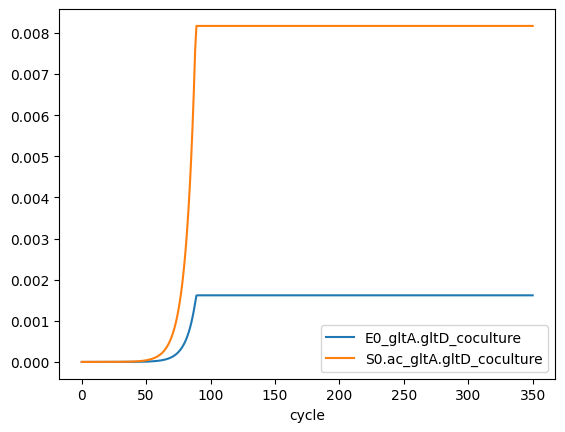

In [590]:
def plot_coculture(gene_list,culture ='coculture' ):
    colnames = list()
    for model, current_gene in itertools.product([E0, S0],convert_arg_to_list(gene_list)):
        colnames.append('_'.join([model.id, current_gene, culture]))
    
    Biomass_df[colnames].plot()
    return None
# plot_coculture(['dadX.pyrD'])
plot_coculture('gltA.gltD')

def get_gcomb_spec_metab(gcomb):
    RP_media = pd.read_json(metabolite_dict['coculture_media_DG'][gcomb])
    spec_metab = RP_media.drop(['x','y'], axis=1).set_index(['metabolite','cycle']).unstack(0).conc_mmol
    spec_metab = spec_metab.loc[:,spec_metab.apply(lambda x: x.min()<30)]
    spec_metab.plot(ylim=(0,0.3))
    return spec_metab

spec_metab = get_gcomb_spec_metab(gcomb)

In [ ]:
# Check spec

In [657]:
full_df.loc['pyrE.pyrD', ['Species','BM_consortia_frac', 'standardized_BM']]
full_df.loc['serC.dapB', ['Species','BM_consortia_frac', 'standardized_BM']]

,Species,BM_consortia_frac,standardized_BM
Gene_inhibition,,,
serC.dapB,E0,0.505905,0.004634
serC.dapB,S0.ac,0.494095,0.013493


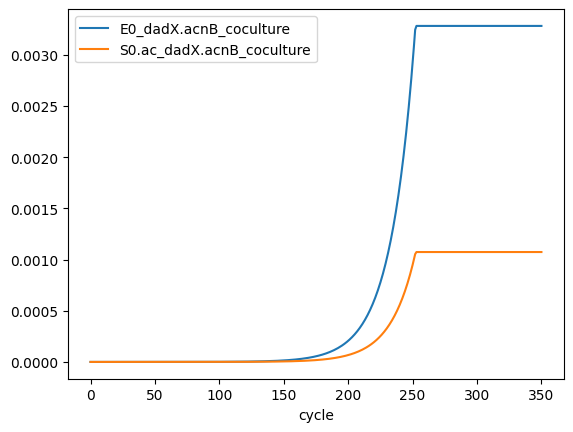

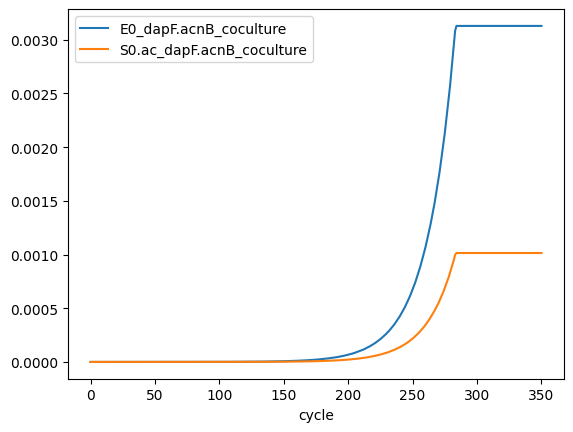

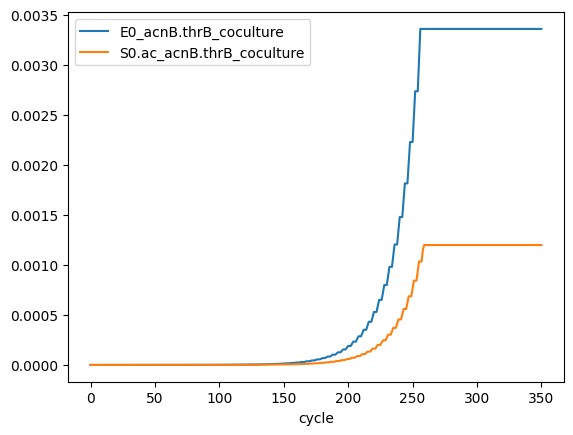

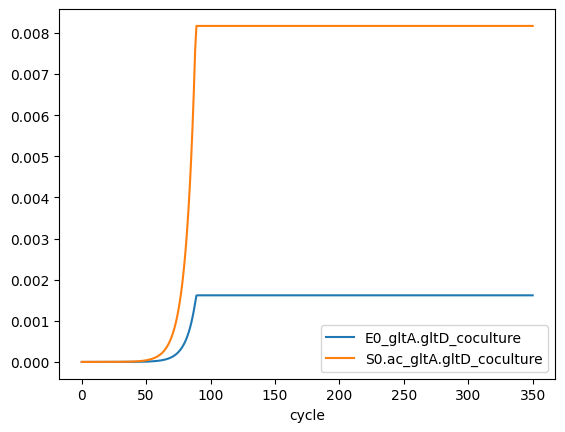

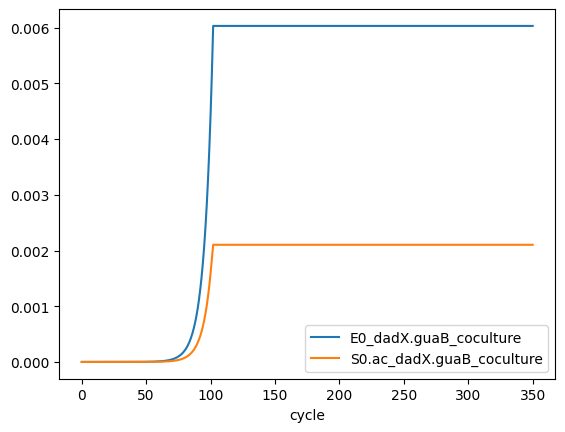

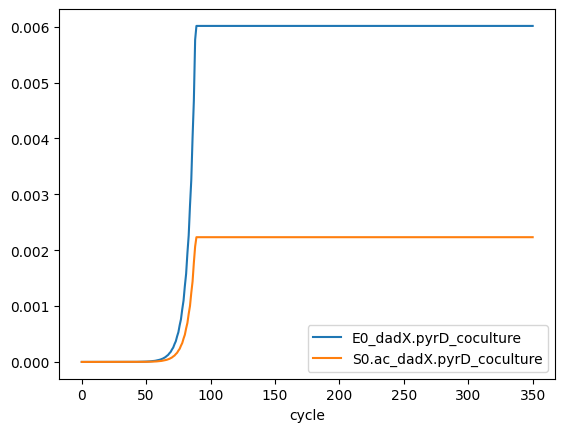

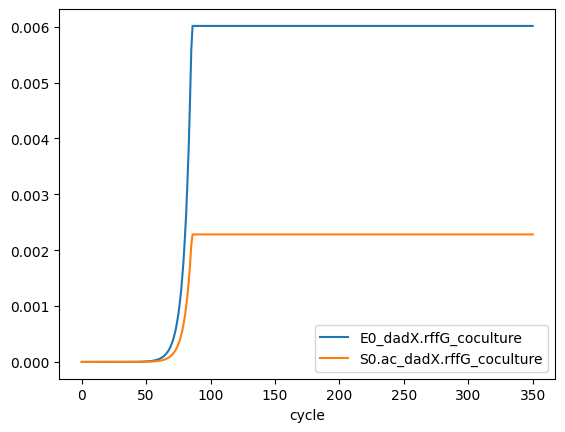

In [705]:
safe_DG_list = depletion_df.loc['DG', 'Depleted']
for gcomb in safe_DG_list:
    plot_coculture(gcomb,'coculture')